In [1]:
!unzip /content/sign_data.zip -d /content/sign_data

Archive:  /content/sign_data.zip
  inflating: /content/sign_data/sign_data/sign_data/test/049/01_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/02_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/03_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/04_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/05_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/06_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/07_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/08_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/09_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/10_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/11_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049/12_049.png  
  inflating: /content/sign_data/sign_data/sign_data/test/049_forg/01_0114049.PN

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skimage.feature import hog
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# 1. Data Loading and Exploration
# ------------------------------

# Define paths
DATASET_PATH = "/content/sign_data/sign_data"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH = os.path.join(DATASET_PATH, "test")

# Function to load data from directory structure
def load_data_from_directory(base_dir):
    image_paths = []
    labels = []
    person_ids = []

    for person_dir in os.listdir(base_dir):
        person_path = os.path.join(base_dir, person_dir)

        if not os.path.isdir(person_path):
            continue

        for file_name in os.listdir(person_path):
            if file_name.endswith('.png'):
                image_path = os.path.join(person_path, file_name)

                # Extract person ID from directory name
                person_id = person_dir

                # Determine if genuine or forged
                is_genuine = 1 if "genuine" in person_dir.lower() else 0

                image_paths.append(image_path)
                labels.append(is_genuine)
                person_ids.append(person_id)

    return pd.DataFrame({
        'image_path': image_paths,
        'label': labels,
        'person_id': person_ids
    })

# Load training and testing data
print("Loading data...")
train_df = load_data_from_directory(TRAIN_PATH)
test_df = load_data_from_directory(TEST_PATH)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Display sample data
print("\nTraining data sample:")
print(train_df.head())

# Data distribution
print("\nLabel distribution in training data:")
print(train_df['label'].value_counts())


Loading data...
Train data shape: (771, 3)
Test data shape: (252, 3)

Training data sample:
                                          image_path  label person_id
0  /content/sign_data/sign_data/train/015_forg/02...      0  015_forg
1  /content/sign_data/sign_data/train/015_forg/01...      0  015_forg
2  /content/sign_data/sign_data/train/015_forg/01...      0  015_forg
3  /content/sign_data/sign_data/train/015_forg/02...      0  015_forg
4  /content/sign_data/sign_data/train/015_forg/02...      0  015_forg

Label distribution in training data:
label
0    771
Name: count, dtype: int64



Loading and preprocessing images...
X_train shape: (771, 128, 128, 1)
X_test shape: (252, 128, 128, 1)


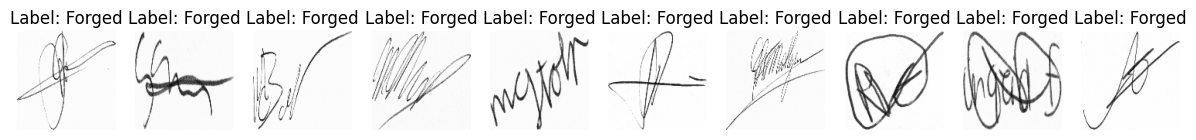

In [17]:
# 2. Data Preprocessing and Visualization
# ---------------------------------------

# Function to preprocess images
def preprocess_image(image_path, target_size=(128, 128), normalize=True):
    """Load and preprocess image from path"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # Resize image
    img = cv2.resize(img, target_size)

    # Normalize pixel values
    if normalize:
        img = img / 255.0

    return img

# Function to load images and labels
def load_images_and_labels(df, target_size=(128, 128)):
    images = []
    labels = []

    for _, row in df.iterrows():
        img = preprocess_image(row['image_path'], target_size)
        if img is not None:
            images.append(img)
            labels.append(row['label'])

    # Convert to numpy arrays and reshape
    X = np.array(images).reshape(-1, target_size[0], target_size[1], 1)
    y = np.array(labels)

    return X, y

# Set image dimensions
IMG_WIDTH, IMG_HEIGHT = 128, 128

# Load and preprocess training and testing images
print("\nLoading and preprocessing images...")
X_train, y_train = load_images_and_labels(train_df, (IMG_WIDTH, IMG_HEIGHT))
X_test, y_test = load_images_and_labels(test_df, (IMG_WIDTH, IMG_HEIGHT))

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Visualize sample images
def visualize_samples(X, y, n_samples=10):
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))

    for i in range(n_samples):
        idx = np.random.randint(0, len(X))
        axes[i].imshow(X[idx].reshape(IMG_WIDTH, IMG_HEIGHT), cmap='gray')
        axes[i].set_title(f"Label: {'Genuine' if y[idx] == 1 else 'Forged'}")
        axes[i].axis('off')

    plt.show()
    plt.tight_layout()
    plt.savefig('sample_signatures.png')
    plt.close()

# Visualize samples
visualize_samples(X_train, y_train)

## VAE IMPLEMENTATION

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.losses import binary_crossentropy

LATENT_DIM = 64  # Dimension of the latent space
beta = 4.0  # Weighting factor for the KL divergence loss

# Encoder
def build_encoder(input_shape):
    """
      Builds the encoder part of the Variational Autoencoder (VAE) model.
      It consists of convolutional layers followed by fully connected layers to
      output the mean and log variance for the latent space. The reparameterization
      trick is used to sample latent variables.

      Args:
          input_shape: Shape of the input data (height, width, channels).

      Returns:
          encoder: A Keras Model that represents the encoder.
      """

    encoder_inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    z_mean = layers.Dense(LATENT_DIM, name='z_mean')(x)
    z_log_var = layers.Dense(LATENT_DIM, name='z_log_var')(x)

    # Sampling using reparameterization trick
    def sampling(args):
        """
          Samples a latent variable using the reparameterization trick.

          Args:
              args: List containing z_mean and z_log_var.

          Returns:
              A tensor representing the sampled latent variable.
          """
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], LATENT_DIM))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(LATENT_DIM,), name='z')([z_mean, z_log_var])

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

# Decoder
def build_decoder(output_shape):
    """
      Builds the decoder part of the Variational Autoencoder (VAE) model.
      It consists of fully connected and transposed convolutional layers to
      generate the output from the latent space.

      Args:
          output_shape: Shape of the output data (height, width, channels).

      Returns:
          decoder: A Keras Model that represents the decoder.
      """
    decoder_inputs = layers.Input(shape=(LATENT_DIM,))
    x = layers.Dense(32 * 32 * 64, activation='relu')(decoder_inputs)
    x = layers.Reshape((32, 32, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    decoder = Model(decoder_inputs, decoder_outputs, name="decoder")
    return decoder

# VAE Model
class VAE(Model):
    """
      Variational Autoencoder (VAE) model that integrates both encoder and decoder.
      This class handles the training and testing steps, including the computation
      of the reconstruction loss and the KL divergence loss.

      Attributes:
          encoder: A Keras Model representing the encoder.
          decoder: A Keras Model representing the decoder.
          optimizer: Optimizer used for training the model.
      """
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                binary_crossentropy(K.flatten(data), K.flatten(reconstruction))
            )
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # reconstruction_loss = tf.reduce_mean(
        #     binary_crossentropy(K.flatten(data), K.flatten(reconstruction))
        # )
        reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction))

        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
        total_loss = reconstruction_loss + beta * kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [19]:
# Input shape
input_shape = (IMG_WIDTH, IMG_HEIGHT, 1)

# Build encoder and decoder
encoder = build_encoder(input_shape)
decoder = build_decoder(input_shape)

# Create VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# Train the VAE
vae.fit(X_train, epochs=500, batch_size=64, validation_data=(X_test, None))


Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 719ms/step - kl_loss: 0.1676 - loss: 0.8296 - reconstruction_loss: 0.6620 - val_kl_loss: 3.4934e-04 - val_loss: 0.0916 - val_reconstruction_loss: 0.0902
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - kl_loss: 0.0018 - loss: 0.3516 - reconstruction_loss: 0.3498 - val_kl_loss: 1.6480e-04 - val_loss: 0.0196 - val_reconstruction_loss: 0.0189
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - kl_loss: 8.4312e-04 - loss: 0.2685 - reconstruction_loss: 0.2676 - val_kl_loss: 4.9350e-04 - val_loss: 0.0199 - val_reconstruction_loss: 0.0180
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - kl_loss: 2.1058e-04 - loss: 0.2397 - reconstruction_loss: 0.2395 - val_kl_loss: 9.5411e-05 - val_loss: 0.0174 - val_reconstruction_loss: 0.0170
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - kl_loss: 8.0956e-05 - loss: 0.2336 - reconstruction_loss: 0.2336 - val_kl_loss: 3.4209e-05 - val_loss: 0.0167 - val_reconstruction_loss: 0.0166
Epoch 6/500
13/1

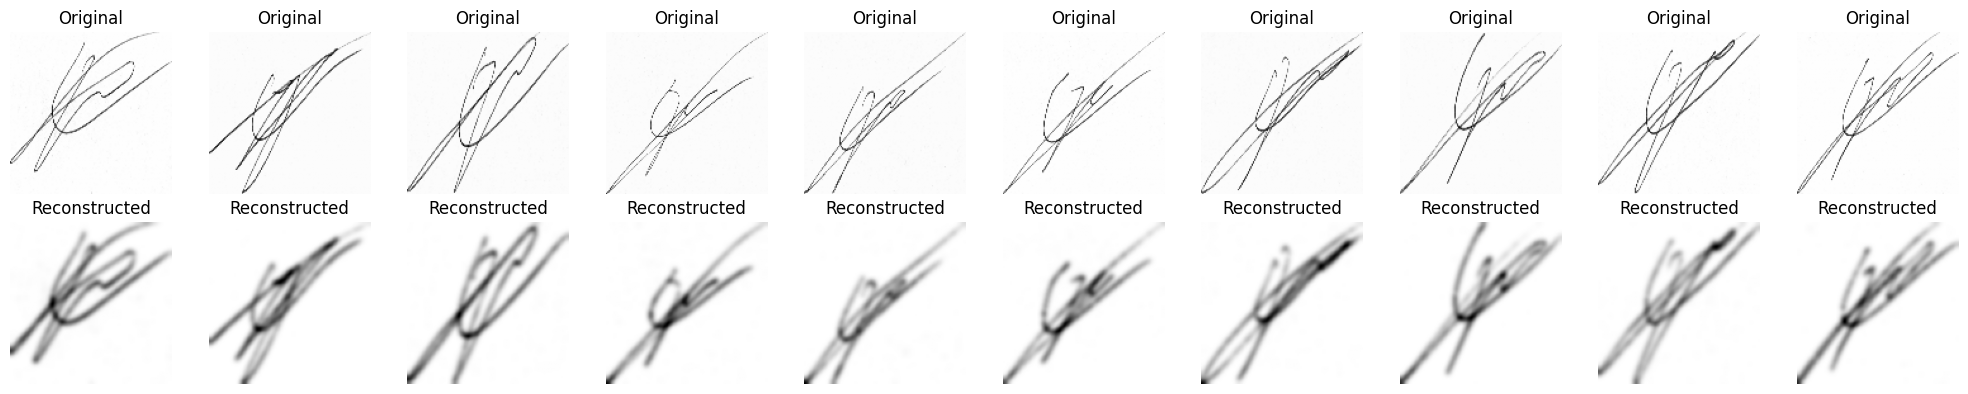

In [21]:
# Visualize original vs reconstructed images
def visualize_reconstructions(model, X, num_images=10):
    """
      Visualizes the original and reconstructed images for a set of input data.

      Args:
          model: The trained VAE model.
          X: Input data to generate reconstructions.
          num_images: The number of images to visualize.
      """
    z_mean, _, _ = model.encoder.predict(X[:num_images])
    reconstructed = model.decoder.predict(z_mean)

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(X[i].reshape(IMG_WIDTH, IMG_HEIGHT), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].reshape(IMG_WIDTH, IMG_HEIGHT), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()
    plt.tight_layout()
    plt.close()

visualize_reconstructions(vae, X_test)


## GAN IMPLEMENTATION

In [12]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)

IMG_SHAPE = (128, 128, 1)  # Shape of the input image
NOISE_DIM = 100  # Dimensionality of the noise vector
BATCH_SIZE = 64  # Batch size for training
EPOCHS = 1000  # Number of training epochs

# Normalize training data again for safety
X_train_gan = X_train.astype('float32')
X_train_gan = (X_train_gan - 0.5) / 0.5  # Rescale to [-1, 1]

# ---------------------------
# Generator Model
# ---------------------------
def build_generator():
    """
    Builds the generator part of the GAN model. The generator creates new images
    from random noise using transposed convolution layers.

    Returns:
        model: A Keras Sequential model representing the generator.
    """
    model = tf.keras.Sequential([
        layers.Dense(16*16*256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((16, 16, 256)),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# ---------------------------
# Discriminator Model
# ---------------------------
def build_discriminator():
    """
    Builds the discriminator part of the GAN model. The discriminator classifies
    images as real or fake using convolution layers.

    Returns:
        model: A Keras Sequential model representing the discriminator.
    """
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=IMG_SHAPE),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# ---------------------------
# Loss and Optimizers
# ---------------------------
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    """
    Computes the loss for the discriminator. The loss is calculated as the binary
    cross-entropy between the real and fake outputs.

    Args:
        real_output: Output of the discriminator for real images.
        fake_output: Output of the discriminator for generated (fake) images.

    Returns:
        loss: Total loss for the discriminator.
    """
    return cross_entropy(tf.ones_like(real_output), real_output) + \
           cross_entropy(tf.zeros_like(fake_output), fake_output)

def generator_loss(fake_output):
    """
    Computes the loss for the generator. The loss is calculated as the binary
    cross-entropy between the target of 1 (real) and the fake output of the discriminator.

    Args:
        fake_output: Output of the discriminator for generated (fake) images.

    Returns:
        loss: Total loss for the generator.
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# ---------------------------
# Training Loop
# ---------------------------
@tf.function
def train_step(images):
    """
    Executes one training step. This includes generating fake images from random noise,
    passing them through the discriminator, computing the generator and discriminator
    losses, and applying gradients to update the model weights.

    Args:
        images: A batch of real images used to train the discriminator.

    Returns:
        gen_loss: Generator loss.
        disc_loss: Discriminator loss.
    """
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

# ---------------------------
# Training the GAN
# ---------------------------
seed = tf.random.normal([16, NOISE_DIM])  # fixed noise for visualization

def train(dataset, epochs):
    """
    Trains the GAN for a specified number of epochs. It loops through the dataset
    in batches, performs training steps, and prints the loss values periodically.

    Args:
        dataset: The training dataset used to train the model.
        epochs: The number of epochs to train the model.
    """
    for epoch in range(epochs):
        idx = np.random.randint(0, dataset.shape[0], BATCH_SIZE)
        image_batch = dataset[idx]

        gen_loss, disc_loss = train_step(image_batch)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}")

# Start training
train(X_train_gan, EPOCHS)


Epoch 0, Gen Loss: 0.7000, Disc Loss: 1.3815
Epoch 10, Gen Loss: 0.8664, Disc Loss: 0.6327
Epoch 20, Gen Loss: 1.4393, Disc Loss: 0.3173
Epoch 30, Gen Loss: 4.0561, Disc Loss: 0.0317
Epoch 40, Gen Loss: 2.2786, Disc Loss: 0.1100
Epoch 50, Gen Loss: 5.3319, Disc Loss: 0.0209
Epoch 60, Gen Loss: 3.2617, Disc Loss: 0.0607
Epoch 70, Gen Loss: 3.6696, Disc Loss: 0.0272
Epoch 80, Gen Loss: 5.0887, Disc Loss: 0.0244
Epoch 90, Gen Loss: 3.9812, Disc Loss: 0.0201
Epoch 100, Gen Loss: 5.6220, Disc Loss: 0.0057
Epoch 110, Gen Loss: 5.1871, Disc Loss: 0.0080
Epoch 120, Gen Loss: 3.3989, Disc Loss: 0.0386
Epoch 130, Gen Loss: 5.1511, Disc Loss: 0.0133
Epoch 140, Gen Loss: 5.4685, Disc Loss: 0.0245
Epoch 150, Gen Loss: 4.6438, Disc Loss: 0.0922
Epoch 160, Gen Loss: 4.1918, Disc Loss: 0.0401
Epoch 170, Gen Loss: 4.6888, Disc Loss: 0.0300
Epoch 180, Gen Loss: 4.9227, Disc Loss: 0.0206
Epoch 190, Gen Loss: 5.3558, Disc Loss: 0.0166
Epoch 200, Gen Loss: 6.8949, Disc Loss: 0.0377
Epoch 210, Gen Loss: 5.1

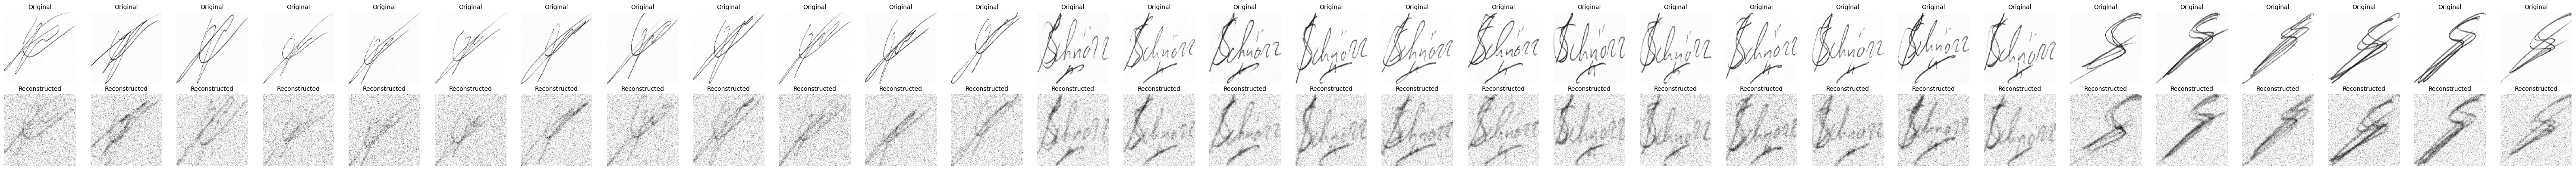

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
latent_dim = 100  # Change this if your GAN uses a different latent vector size
IMG_WIDTH = 128   # Width of your images
IMG_HEIGHT = 128  # Height of your images

# --- Visualization Function ---
def plot_original_vs_generated(originals, generated, n=10):
    """Display 'Original' and 'Reconstructed' signature images in a horizontal layout like the sample image."""
    plt.figure(figsize=(2 * n, 4))  # Adjust width for spacing

    for i in range(n):
        # Original image
        plt.subplot(2, n, i + 1)
        plt.imshow(originals[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        plt.title("Original", fontsize=10)
        plt.axis('off')

        # Generated image
        plt.subplot(2, n, i + n + 1)
        plt.imshow(generated[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        plt.title("Reconstructed", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("original_vs_generated.png")
    plt.show()

# --- Generate and Compare ---
n_samples = 30
original_samples = X_test[:n_samples]  # Assuming X_test contains original images

# Random noise for GAN
noise = np.random.normal(0, 1, (n_samples, latent_dim))
generated_samples = generator.predict(noise)

# Plot comparison
plot_original_vs_generated(original_samples, generated_samples, n=n_samples)
